<a href="https://colab.research.google.com/github/tszabad/FCC_dataanalytics/blob/master/wine_quality_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from __future__ import absolute_import, division, print_function, unicode_literals


from IPython.display import clear_output

print(tf.__version__)

     |████████████████████████████████| 1.0MB 12.2MB/s 
2.4.1


In [3]:
# Import data

dataset = pd.read_csv('//winequality-red.csv', sep=";")
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
dataset.isna().sum()
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
dataset = dataset.rename(columns={'fixed acidity': 'fixed_acidity', 'volatile acidity': 'volatile_acidity',"citric acid":"citric_acid","residual sugar":"residual_sugar","free sulfur dioxide":"free_sulfurdioxide","total sulfur dioxide":"total_sulfurdioxide" })
dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfurdioxide,total_sulfurdioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
dataset.shape

(1599, 12)

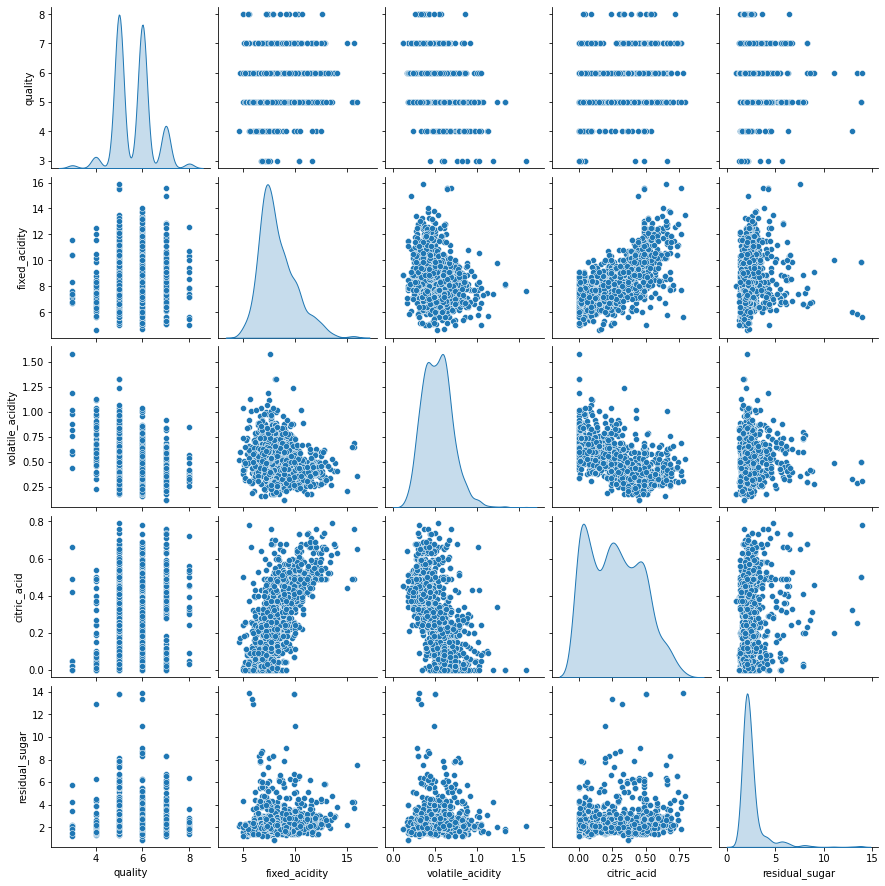

In [7]:
train = dataset.sample(frac=0.8,random_state=0)
test = dataset.drop(train.index)

sns.pairplot(train[["quality", "fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar"]], diag_kind="kde")

In [8]:
train_stats = train.describe()
train_stats.pop("quality")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1279.0,8.310164,1.744190,4.60000,7.1000,7.90000,9.250000,15.9000
volatile_acidity,1279.0,0.525571,0.176645,0.12000,0.3900,0.52000,0.635000,1.5800
citric_acid,1279.0,0.271618,0.196822,0.00000,0.0900,0.26000,0.430000,0.7900
residual_sugar,1279.0,2.516341,1.300985,0.90000,1.9000,2.20000,2.600000,13.9000
chlorides,1279.0,0.087347,0.045666,0.01200,0.0710,0.07900,0.091000,0.6110
free_sulfurdioxide,1279.0,15.868647,10.438880,1.00000,7.0000,14.00000,21.000000,72.0000
total_sulfurdioxide,1279.0,46.488663,32.952841,6.00000,22.0000,38.00000,62.000000,289.0000
density,1279.0,0.996739,0.001888,0.99007,0.9956,0.99676,0.997855,1.0032
pH,1279.0,3.312588,0.153923,2.87000,3.2100,3.31000,3.400000,4.0100
sulphates,1279.0,0.655012,0.160192,0.33000,0.5500,0.62000,0.730000,1.9800


In [9]:
train_y = train.pop('quality')
test_y = test.pop('quality')

In [10]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='fixed_acidity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='volatile_acidity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='citric_acid', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='residual_sugar', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='chlorides', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='free_sulfurdioxide', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='total_sulfurdioxide', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='density', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='pH', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='sulphates', shape=(1,), default_va

In [35]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[60, 10],
    # The model must choose between 3 classes.
    n_classes=11)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp9oja2jt0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [36]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp9oja2jt0/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 8.543475, step = 0
INFO:tensorflow:global_step/sec: 259.143
INFO:tensorflow:loss = 1.6527498, step = 100 (0.388 sec)
INFO:tensorflow:global_step/sec: 325.666
INFO:tensorflow:loss = 1.2375929, step = 200 (0.309 sec)
INFO:tensorflow:global_step/sec: 301.467
INFO:tensorflow:loss = 1.2477324, step = 300 (0.329 sec)
INFO:tensorflow:global_step/sec: 309.982
INFO:tensorflow:loss = 1.2259371, step = 400 (0.326 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500...
INFO:tensorflow:Saving check

In [37]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-02-07T17:00:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9oja2jt0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.24680s
INFO:tensorflow:Finished evaluation at 2021-02-07-17:00:36
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.484375, average_loss = 1.2394464, global_step = 500, loss = 1.1835215
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmp9oja2jt0/model.ckpt-500

Test set accuracy: 0.484



In [57]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

for j in range(10,20): 
  predict = {}
  for i, col in enumerate(dataset.columns): 
      predict[col] = [float(dataset.loc[j][i])]

  


  predictions = classifier.predict(input_fn=lambda: input_fn(predict))
  for pred_dict in predictions:
      class_id = pred_dict['class_ids'][0]
      probability = pred_dict['probabilities'][class_id]

      print('Prediction is "{}" ({:.1f}%)'.format(
         class_id, 100 * probability))
  print("the actual value is " +str(dataset.loc[j][11]))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9oja2jt0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "5" (59.9%)
the actual value is 5.0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9oja2jt0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "5" (72.6%)
the actual value is 5.0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp9oja2jt0/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "5" (57.9%)
the actual value is 5.0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow